In [76]:
import numpy as np
import pandas as pd
pd.set_option('max_rows', 1000)

First we need to import the stock 'world'. The 10 stocks that we need to analyze:

In [77]:
def CalcDiv(df):
    '''
    Takes in a df with 7 columns, and returns a df with a Dividend Column
    '''
    df['Close_Ratio'] = df.Close.shift(1) / df.Close
    df['Adj_Close_Ratio'] = df['Adj Close'].shift(1) / df['Adj Close']
    df['Close_diff'] = df['Close_Ratio'] - df['Adj_Close_Ratio']
    df['Dividend'] = (df['Close_diff'] * df['Close']).round(4)
    
    df = df.drop(['Close_Ratio','Adj_Close_Ratio','Close_diff'],axis=1)
    
    return df

In [78]:
universe = ['IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN', 'FB', 'NFLX', 'TSLA', 'ORCL', 'SAP']
df = {} #Define a dict to hold the dataframe keyed to the stock name
for stock in universe:
    dataframe = pd.read_csv('stocks/'+stock+'.csv',parse_dates=['Date'])
    dataframe = CalcDiv(dataframe)
    dataframe = dataframe.set_index('Date')
    dataframe.index = pd.to_datetime(dataframe.index)
    df[stock] = dataframe

In [79]:
df['IBM'].head()

,Open,High,Low,Close,Adj Close,Volume,Dividend
Date,,,,,,,
2018-01-02,154.500000,154.809998,153.539993,154.250000,142.483978,4202500,NaN
2018-01-03,157.339996,159.809998,156.330002,158.490005,146.400558,9441600,-0.0
2018-01-04,159.649994,162.320007,159.369995,161.699997,149.365707,7556200,0.0
2018-01-05,162.440002,162.899994,161.100006,162.490005,150.095444,5195800,-0.0
2018-01-08,162.660004,163.910004,161.699997,163.470001,151.000687,5237500,0.0


Now we start giving ourselves the $5M in cash:

In [80]:
df['IBM'].loc['2018-02-08']

Open         1.524800e+02
High         1.531600e+02
Low          1.475000e+02
Close        1.475900e+02
Adj Close    1.376743e+02
Volume       6.779100e+06
Dividend     1.500000e+00
Name: 2018-02-08 00:00:00, dtype: float64

In [81]:
cash_in_hand = 5000000
stocks_to_buy = ['IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN']
num_stocks_bought = {} #Shares that were bought
cash_per_stock = cash_in_hand / len(stocks_to_buy)
for stock in stocks_to_buy:
    num_stocks_bought[stock] = cash_per_stock // df[stock].loc['2018-01-02'].Close
    cash_in_hand -= (df[stock].loc['2018-01-02'].Close * num_stocks_bought[stock])

In [82]:
cash_in_hand

1312.545517000137

Now we want to rebalance our portfolio. Lets define a function to do so:

In [83]:
def RebalanceStocksLow(df,num_stocks_bought,cash_in_hand,prev_date,curr_date):
    '''
    Rebalances stocks: Takes the stock 'universe' stocks bought until now, cash in hand, the previous date,
    and the date to rebalance on. 
    Returns the new number of stocks bought, and the new balance of cash in hand
    '''
    #Sell off current stocks and add to cash in hand
    for stock in num_stocks_bought:
        cash_in_hand += num_stocks_bought[stock] * df[stock].loc[curr_date].Close
    #print('MTM: ',cash_in_hand)
    
    #Now lets see what are the 5 stocks that have dropped the most
    stock_drops = {}
    for stock in df:
        stock_drops[stock] = (df[stock].loc[prev_date]['Adj Close'] - df[stock].loc[curr_date]['Adj Close'])/df[stock].loc[prev_date]['Adj Close']
    stocks_to_buy = sorted(stock_drops, key=stock_drops.get,reverse=True)[0:5]
    
    #Now lets buy the new stocks
    cash_per_stock = cash_in_hand / len(stocks_to_buy)
    num_stocks_bought = {}
    for stock in stocks_to_buy:
        num_stocks_bought[stock] = cash_per_stock // df[stock].loc[curr_date].Close
        cash_in_hand -= (df[stock].loc[curr_date].Close * num_stocks_bought[stock])
        
    return cash_in_hand, num_stocks_bought

In [84]:
def RebalanceStocksHigh(df,num_stocks_bought,cash_in_hand,prev_date,curr_date):
    '''
    Rebalances stocks: Takes the stock 'universe' stocks bought until now, cash in hand, the previous date,
    and the date to rebalance on. 
    Returns the new number of stocks bought, and the new balance of cash in hand
    '''
    #Sell off current stocks and add to cash in hand
    for stock in num_stocks_bought:
        cash_in_hand += num_stocks_bought[stock] * df[stock].loc[curr_date].Close
    #print('MTM: ',cash_in_hand)
    
    #Now lets see what are the 5 stocks that have increased the most
    stock_drops = {}
    for stock in df:
        stock_drops[stock] = (df[stock].loc[prev_date]['Adj Close'] - df[stock].loc[curr_date]['Adj Close'])/df[stock].loc[prev_date]['Adj Close']
    stocks_to_buy = sorted(stock_drops, key=stock_drops.get)[0:5]
    
    #Now lets buy the new stocks
    cash_per_stock = cash_in_hand / len(stocks_to_buy)
    num_stocks_bought = {}
    for stock in stocks_to_buy:
        num_stocks_bought[stock] = cash_per_stock // df[stock].loc[curr_date].Close
        cash_in_hand -= (df[stock].loc[curr_date].Close * num_stocks_bought[stock])
        
    return cash_in_hand, num_stocks_bought

In [85]:
def sumDividend(df,num_stocks_bought,date):
    '''
    Takes in the stock universe, the stocks we have bought, the cash on hand, and the date, 
    and adds the dividend amount to the cash_in_hand. Returns updated cash_in_hand.
    '''
    dividend = 0
    for stock in num_stocks_bought:
        dividend += num_stocks_bought[stock] * np.nan_to_num(df[stock].loc[date]['Dividend'])
    
    return dividend

In [86]:
cash_in_hand, num_stocks_bought = RebalanceStocksLow(df,num_stocks_bought,cash_in_hand,'2018-01-02','2018-01-09')
print(cash_in_hand, num_stocks_bought)

1047.8680820005247 {'AAPL': 5957.0, 'SAP': 9097.0, 'MSFT': 11772.0, 'FB': 5528.0, 'GOOG': 938.0}


In [87]:
cash_in_hand = 5000000
stocks_to_buy = ['IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN']
num_stocks_bought = {} #Shares that were bought
cash_per_stock = cash_in_hand / len(stocks_to_buy)
MTM = 0
for stock in stocks_to_buy:
    num_stocks_bought[stock] = cash_per_stock // df[stock].loc['2018-01-02'].Close
    cash_in_hand -= (df[stock].loc['2018-01-02'].Close * num_stocks_bought[stock])
    
all_dates = df['IBM'].index.tolist()
prev_date = '2018-01-02'
counter = 0
all_mtms = []
for date in all_dates:
    #print('Date: ',date)
    cash_in_hand += sumDividend(df,num_stocks_bought,date)
    
    if (counter%5 == 0):
        #print(date)
        cash_in_hand, num_stocks_bought = RebalanceStocksLow(df,num_stocks_bought,cash_in_hand,prev_date,date)
        #print(cash_in_hand, num_stocks_bought)
    
    #Add the dividend
    #print(date, sumDividend(df,num_stocks_bought,date))
    
    MTM = cash_in_hand
    for stock in num_stocks_bought:
        MTM += num_stocks_bought[stock] * df[stock].loc[date].Close
        
    all_mtms.append(MTM.round(2))
    counter += 1  
    prev_date = date

MTM_array_low = pd.Series(all_mtms)

In [88]:
cash_in_hand = 5000000
stocks_to_buy = ['IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN']
num_stocks_bought = {} #Shares that were bought
cash_per_stock = cash_in_hand / len(stocks_to_buy)
MTM = 0
for stock in stocks_to_buy:
    num_stocks_bought[stock] = cash_per_stock // df[stock].loc['2018-01-02'].Close
    cash_in_hand -= (df[stock].loc['2018-01-02'].Close * num_stocks_bought[stock])
    
all_dates = df['IBM'].index.tolist()
prev_date = '2018-01-02'
counter = 0
all_mtms = []
for date in all_dates:
    #print('Date: ',date)
    cash_in_hand += sumDividend(df,num_stocks_bought,date)
    
    if (counter%5 == 0):
        #print(date)
        cash_in_hand, num_stocks_bought = RebalanceStocksHigh(df,num_stocks_bought,cash_in_hand,prev_date,date)
        #print(cash_in_hand, num_stocks_bought)
    
    #Add the dividend
    #print(date, sumDividend(df,num_stocks_bought,date))
    
    MTM = cash_in_hand
    for stock in num_stocks_bought:
        MTM += num_stocks_bought[stock] * df[stock].loc[date].Close
        
    all_mtms.append(MTM.round(2))
    counter += 1  
    prev_date = date

MTM_array_high = pd.Series(all_mtms)
#print('MTM: ',MTM_array_high)
MTM_array_high

0      5000000.00
1      5061134.14
2      5103637.21
3      5164048.72
4      5187003.72
5      5192788.32
6      5187192.15
7      5217649.66
8      5272912.16
9      5272994.36
10     5336563.70
11     5331206.74
12     5306725.77
13     5326037.47
14     5365292.32
15     5327767.79
16     5372810.56
17     5471410.97
18     5496678.40
19     5429440.99
20     5467152.93
21     5382456.39
22     5311097.33
23     5129837.31
24     5262344.81
25     5214161.70
26     4942848.40
27     4949811.89
28     5055370.53
29     5104259.36
30     5205201.29
31     5283935.74
32     5247247.44
33     5240137.61
34     5253570.79
35     5253787.52
36     5342095.92
37     5407488.89
38     5342239.14
39     5301162.17
40     5185810.13
41     5239423.35
42     5350907.97
43     5381617.93
44     5418954.63
45     5392924.40
46     5504295.38
47     5533900.13
48     5457363.55
49     5449055.42
50     5449192.55
51     5442822.92
52     5367058.35
53     5246187.81
54     5219180.16
55     510

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

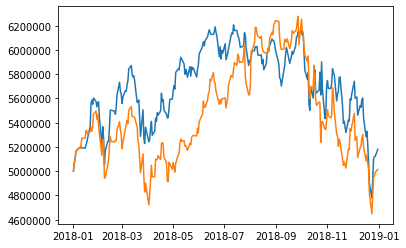

In [90]:
fig = plt.figure()
ax = plt.axes()

ax.plot(pd.Series(all_dates), MTM_array_low)
ax.plot(pd.Series(all_dates), MTM_array_high)

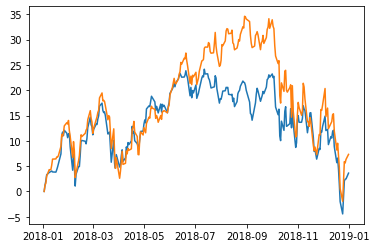

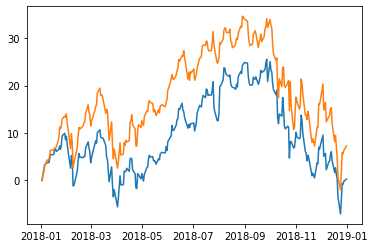

In [91]:
# find the daily high tech index
indexes = df['IBM'].index
high_tech_index = pd.Series(np.zeros(len(indexes)),indexes)
for stock in universe:
    high_tech_index += df[stock].Close
high_tech_index /= 10

# convert series into daily percentage change
high_tech_index_0 = high_tech_index.iloc[0]
high_tech_index_percent = ((high_tech_index-high_tech_index_0)/high_tech_index_0)*100

MTM_array_low_0 = MTM_array_low.iloc[0]
MTM_array_high_0 = MTM_array_low.iloc[0]
MTM_array_low_percent = ((MTM_array_low-MTM_array_low_0)/MTM_array_low_0)*100
MTM_array_high_percent = ((MTM_array_high-MTM_array_high_0)/MTM_array_high_0)*100

# plot the two series (MTM low vs. high tech index)
fig2 = plt.figure()
ax2 = plt.axes()

ax2.plot(indexes, MTM_array_low_percent)
ax2.plot(indexes, high_tech_index_percent)

# plot the two series (MTM high vs. high tech index)
fig3 = plt.figure()
ax3 = plt.axes()

ax3.plot(indexes, MTM_array_high_percent)
ax3.plot(indexes, high_tech_index_percent)

In [92]:
# find optimal days interval to maximize MTM (rebalance low)
def find_max_mtm_low(num_days):
    cash_in_hand = 5000000
    stocks_to_buy = ['IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN']
    num_stocks_bought = {} #Shares that were bought
    cash_per_stock = cash_in_hand / len(stocks_to_buy)
    MTM = 0
    for stock in stocks_to_buy:
        num_stocks_bought[stock] = cash_per_stock // df[stock].loc['2018-01-02'].Close
        cash_in_hand -= (df[stock].loc['2018-01-02'].Close * num_stocks_bought[stock])

    all_dates = df['IBM'].index.tolist()
    prev_date = '2018-01-02'
    counter = 0
    all_mtms = []
    for date in all_dates:
        #print('Date: ',date)
        cash_in_hand += sumDividend(df,num_stocks_bought,date)

        if (counter%num_days == 0):
            #print(date)
            cash_in_hand, num_stocks_bought = RebalanceStocksLow(df,num_stocks_bought,cash_in_hand,prev_date,date)
            #print(cash_in_hand, num_stocks_bought)

        #Add the dividend
        #print(date, sumDividend(df,num_stocks_bought,date))

        MTM = cash_in_hand
        for stock in num_stocks_bought:
            MTM += num_stocks_bought[stock] * df[stock].loc[date].Close

        all_mtms.append(MTM.round(2))
        counter += 1  
        prev_date = date

    MTM_array_low = pd.Series(all_mtms)
    MTM_max = MTM_array_low.iloc[-1]
    return MTM_max

In [93]:
# find optimal days interval to maximize MTM (rebalance low)
all_max_mtms = []
for num_days in range(1,len(all_dates)+1):
    all_max_mtms.append(find_max_mtm_low(num_days))
    
max_MTMs = pd.Series(all_max_mtms, index=np.arange(1,len(all_dates)+1))
max_MTM_num_of_days_idx = max_MTMs.idxmax()
overall_max_MTM = max_MTMs.loc[max_MTM_num_of_days_idx]
print("Optimal days interval to maximize MTM (rebalance low): ", max_MTM_num_of_days_idx)
print("MTM with the optimal days interval is ", overall_max_MTM)

Optimal days interval to maximize MTM (rebalance low):  61
MTM with the optimal days interval is  6226745.79


In [94]:
# find optimal days interval to maximize MTM (rebalance high)
def find_max_mtm_high(num_days):
    cash_in_hand = 5000000
    stocks_to_buy = ['IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN']
    num_stocks_bought = {} #Shares that were bought
    cash_per_stock = cash_in_hand / len(stocks_to_buy)
    MTM = 0
    for stock in stocks_to_buy:
        num_stocks_bought[stock] = cash_per_stock // df[stock].loc['2018-01-02'].Close
        cash_in_hand -= (df[stock].loc['2018-01-02'].Close * num_stocks_bought[stock])

    all_dates = df['IBM'].index.tolist()
    prev_date = '2018-01-02'
    counter = 0
    all_mtms = []
    for date in all_dates:
        #print('Date: ',date)
        cash_in_hand += sumDividend(df,num_stocks_bought,date)

        if (counter%num_days == 0):
            #print(date)
            cash_in_hand, num_stocks_bought = RebalanceStocksHigh(df,num_stocks_bought,cash_in_hand,prev_date,date)
            #print(cash_in_hand, num_stocks_bought)

        #Add the dividend
        #print(date, sumDividend(df,num_stocks_bought,date))

        MTM = cash_in_hand
        for stock in num_stocks_bought:
            MTM += num_stocks_bought[stock] * df[stock].loc[date].Close

        all_mtms.append(MTM.round(2))
        counter += 1  
        prev_date = date

    MTM_array_high = pd.Series(all_mtms)
    MTM_max = MTM_array_high.iloc[-1]
    return MTM_max

In [95]:
# find optimal days interval to maximize MTM (rebalance high)
all_max_mtms = []
for num_days in range(1,len(all_dates)+1):
    all_max_mtms.append(find_max_mtm_high(num_days))
    
max_MTMs = pd.Series(all_max_mtms, index=np.arange(1,len(all_dates)+1))
max_MTM_num_of_days_idx = max_MTMs.idxmax()
overall_max_MTM = max_MTMs.loc[max_MTM_num_of_days_idx]
print("Optimal days interval to maximize MTM (rebalance high): ", max_MTM_num_of_days_idx)
print("MTM with the optimal days interval is ", overall_max_MTM)

Optimal days interval to maximize MTM (rebalance high):  60
MTM with the optimal days interval is  6084005.95
